<a href="https://colab.research.google.com/github/venkatalakshmi03/CMPE256/blob/priyanka/Sequential_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun May  8 20:34:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 7.2 MB/s 
     |████████████████████████████████| 462 kB 45.5 MB/s 


In [3]:
!pip install wordcloud

In [4]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 23 kB/s 


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!unzip /content/drive/MyDrive/Reviews.csv.zip

Archive:  /content/drive/MyDrive/Reviews.csv.zip
  inflating: Reviews.csv             


In [10]:
!ls

drive  Reviews.csv  sample_data


In [12]:
df = pd.read_csv("Reviews.csv")
df.shape

(568454, 10)

# Exploration

In [13]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
df.loc[df['Score'] <=2, 'Sentiment'] = int(0)
df.loc[df['Score'] > 3, 'Sentiment'] = int(1)

In [15]:
df.drop(df[df['Score']==3].index,inplace=True)

In [16]:
df = df[["Text", "Sentiment"]]

In [17]:
df.Sentiment.value_counts()

1.0    443777
0.0     82037
Name: Sentiment, dtype: int64

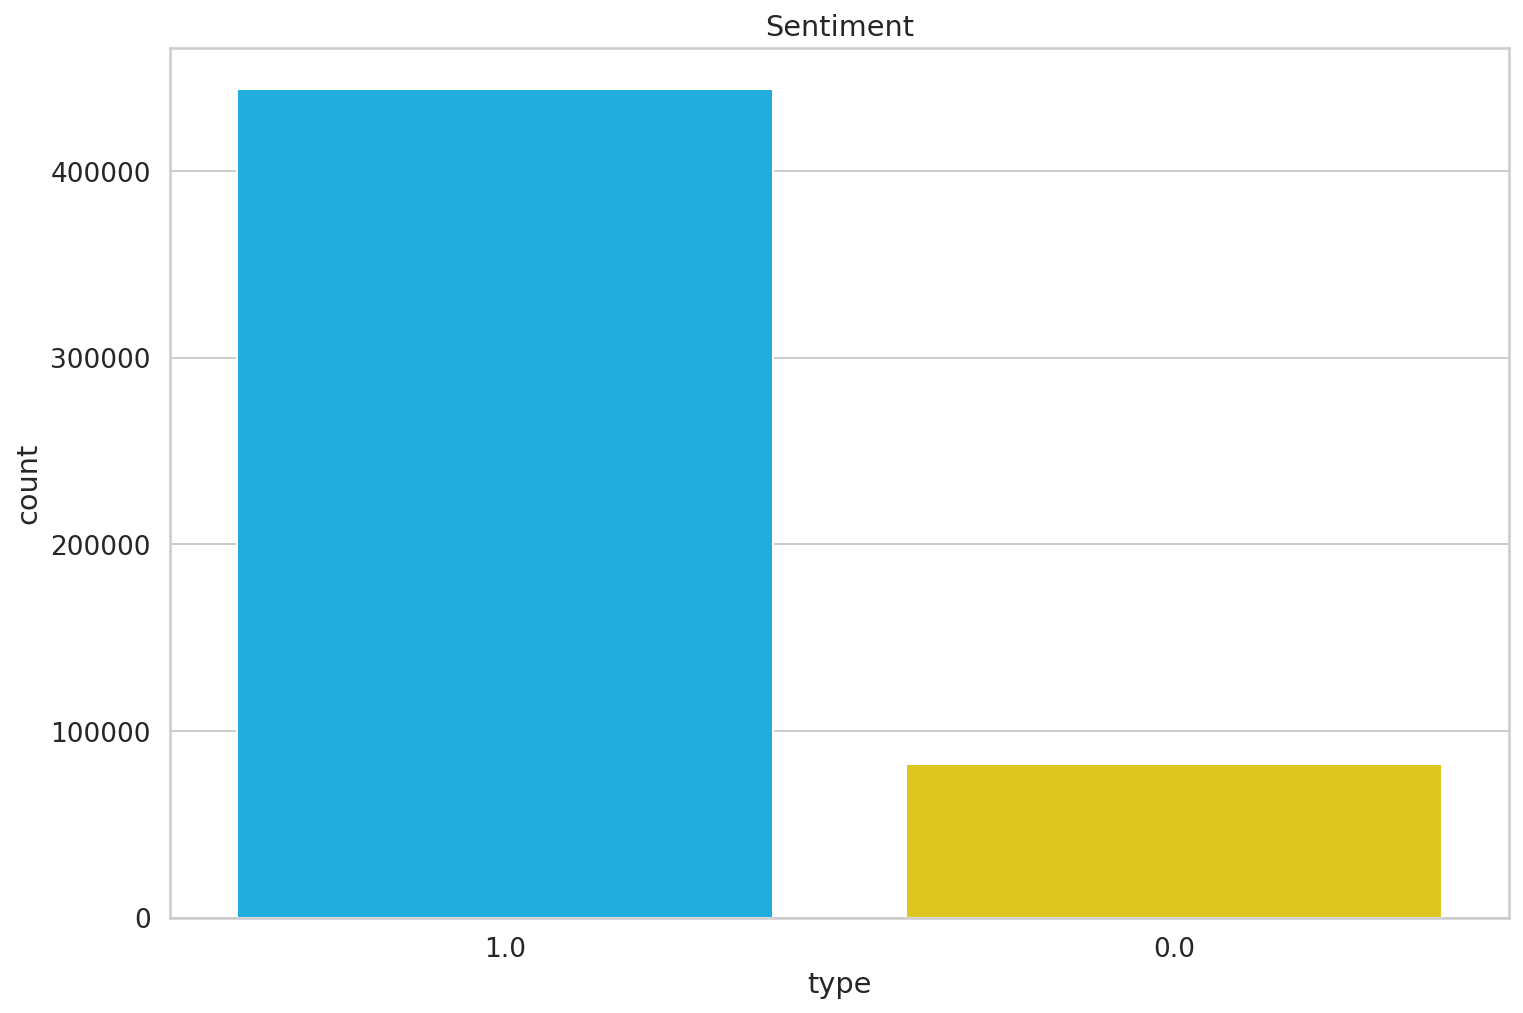

In [18]:
sns.countplot(
  x='Sentiment',
  data=df,
  order=df.Sentiment.value_counts().index
)

plt.xlabel("type")
plt.title("Sentiment");

In [19]:
good_reviews = df[df.Sentiment == 1]
bad_reviews = df[df.Sentiment == 0]

In [20]:
print(good_reviews.shape, bad_reviews.shape)

(443777, 2) (82037, 2)


In [22]:
good_reviews_text = " ".join(good_reviews.Text.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.Text.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [23]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

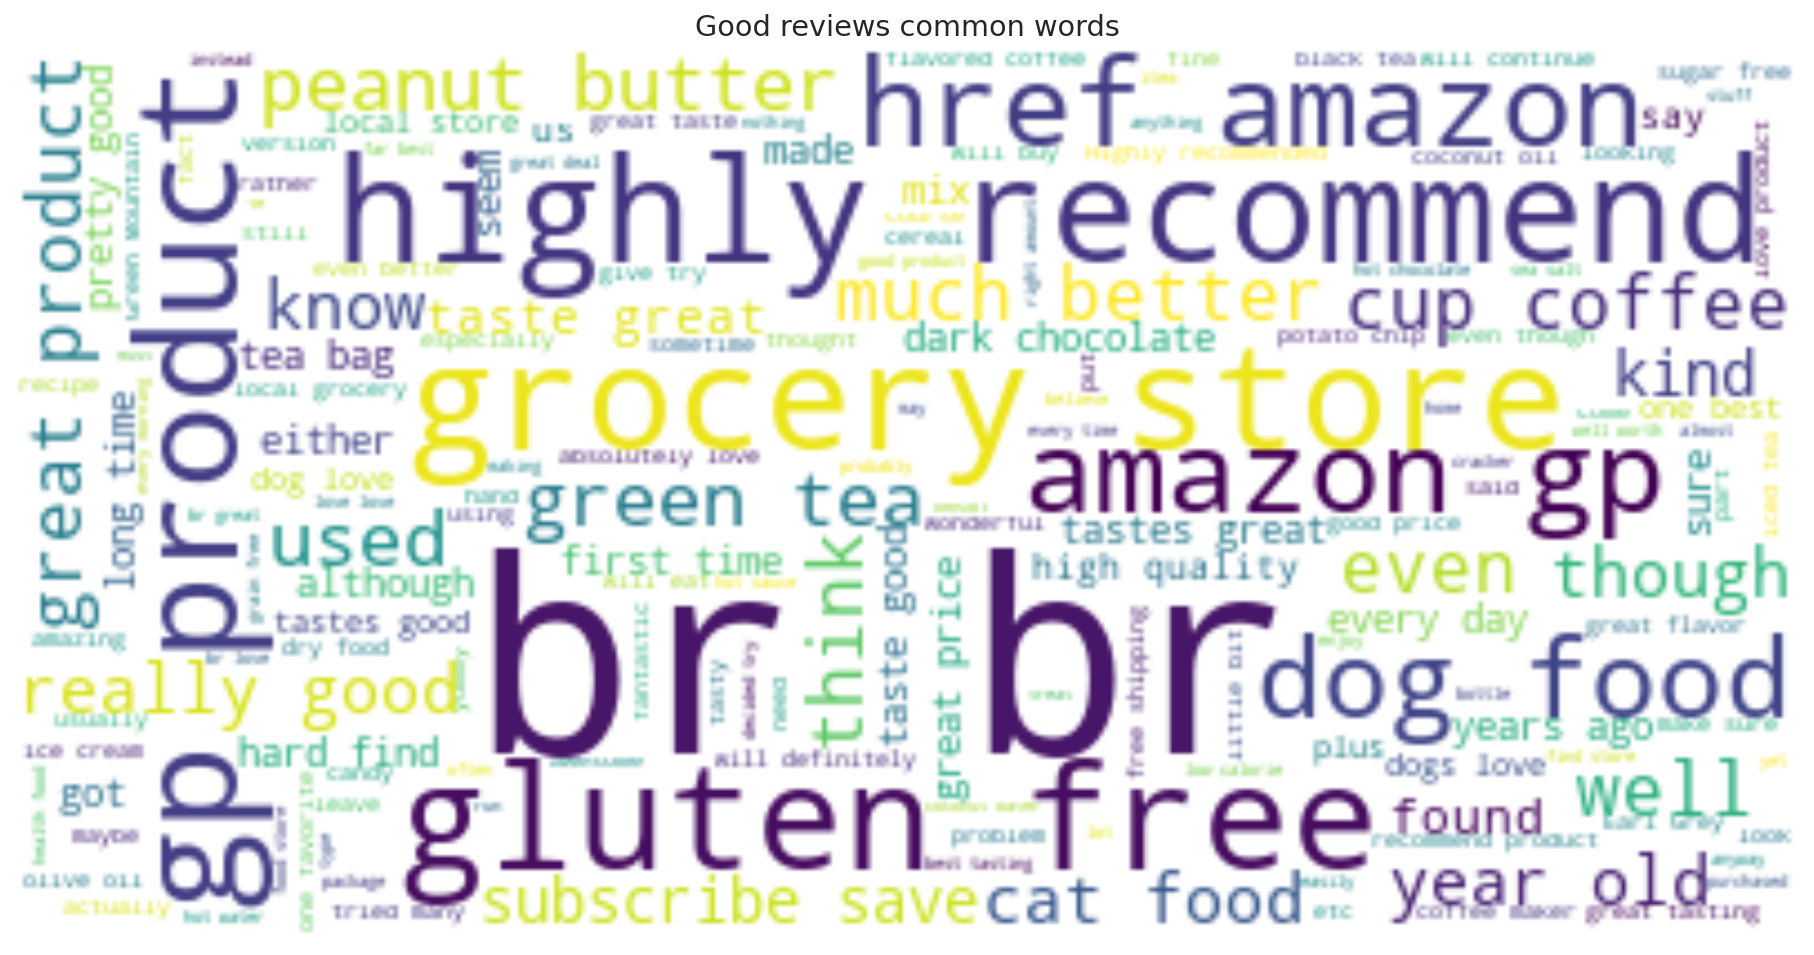

In [24]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")

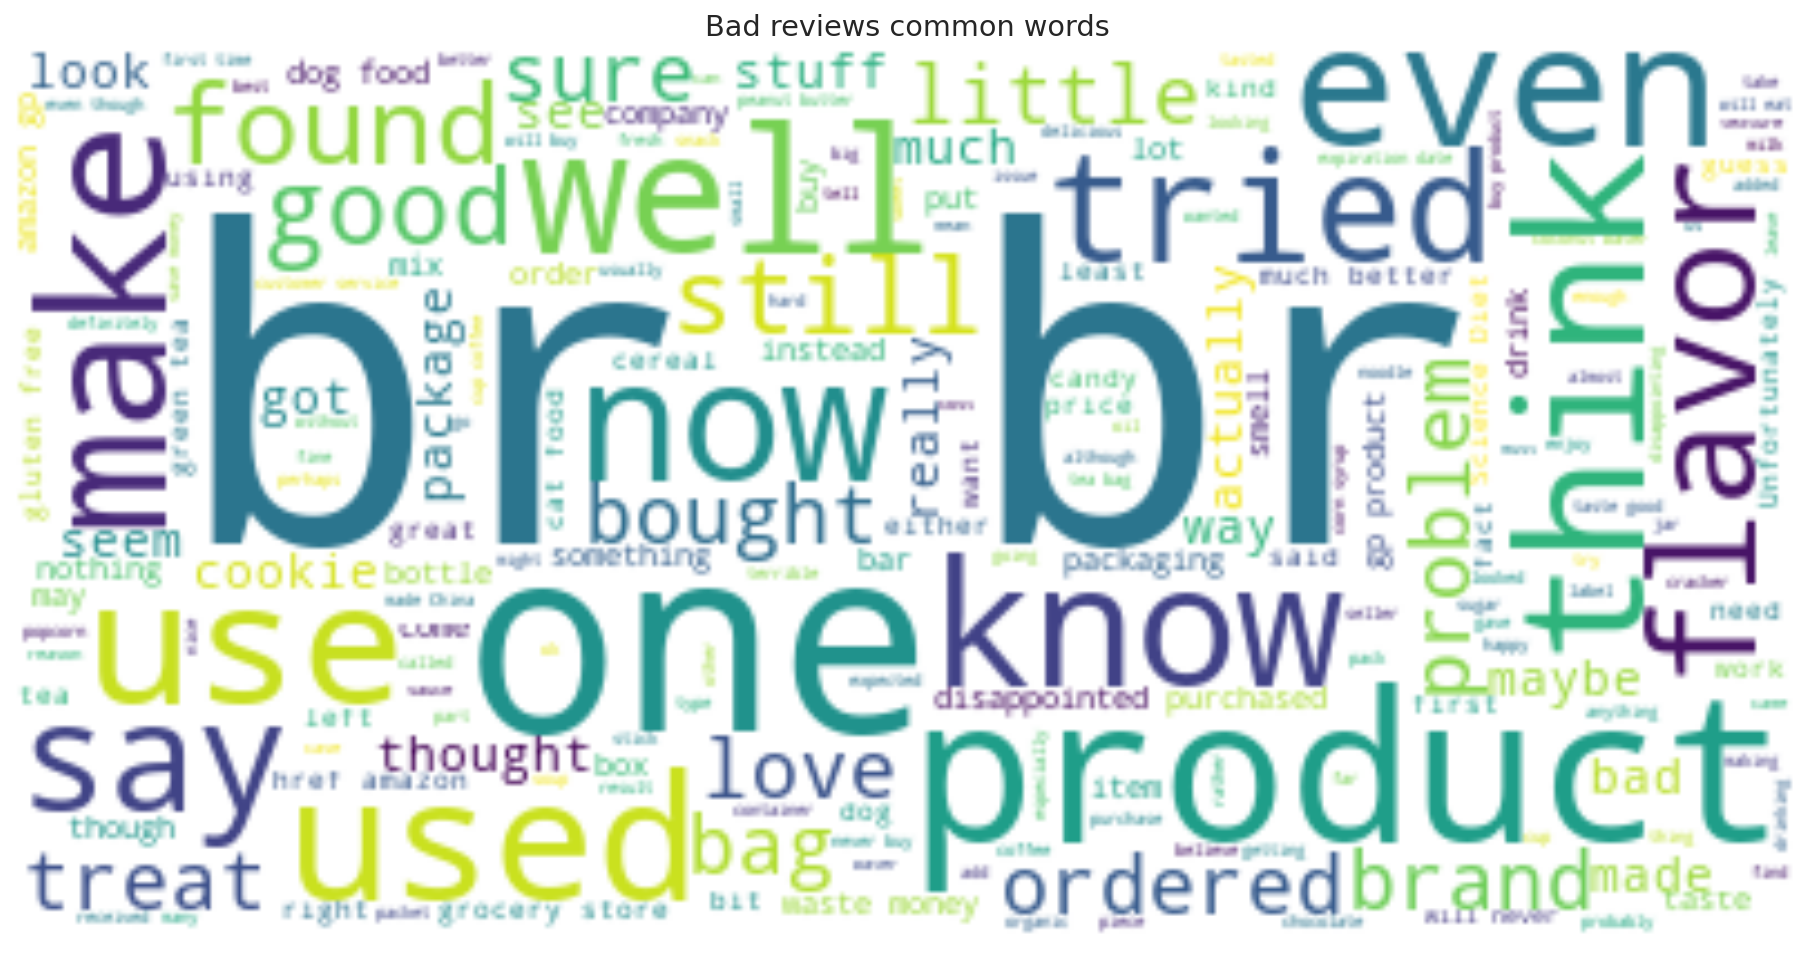

In [25]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

In [26]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)
bad_df = bad_reviews

In [27]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

(164074, 2)

In [28]:
review_df.head()

,Text,Sentiment
0,I have started every morning for the last 7 mo...,1.0
1,Thank goodness this pasta makes life for a glu...,1.0
2,I am the type of person who gets tired and sta...,1.0
3,The flavor of these is just amazing. They are ...,1.0
4,I have been using Coffee People Donut Shop for...,1.0


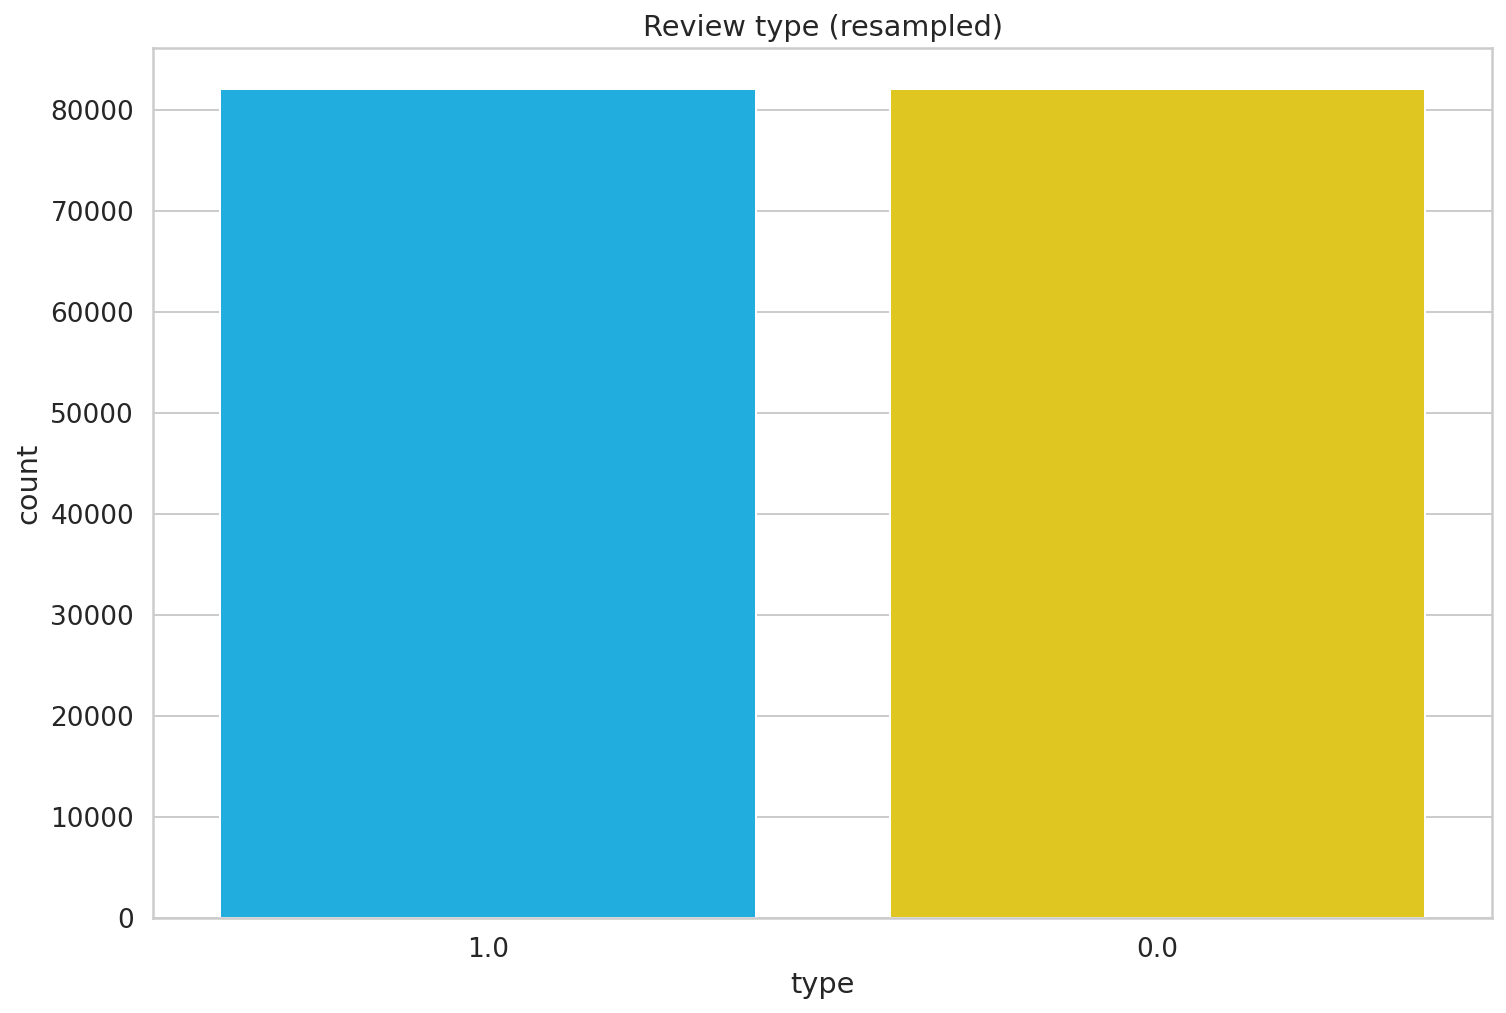

In [29]:
sns.countplot(
  x='Sentiment',
  data=review_df,
  order=review_df.Sentiment.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

# Universal Sentence Encoder

In [30]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [31]:
sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb_1 = use(sent_1)
emb_2 = use(sent_2)

In [32]:
emb_1.shape

TensorShape([1, 512])

In [33]:
np.inner(emb_1, emb_2).flatten()[0]

0.7925467

# Preprocessing

In [34]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.Sentiment.to_numpy().reshape(-1, 1)
)

In [35]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.Text, 
    type_one_hot, 
    test_size=.1, 
    random_state=RANDOM_SEED
  )

In [36]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 147666/147666 [40:08<00:00, 61.31it/s]


In [37]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 16408/16408 [04:20<00:00, 62.96it/s]


In [74]:
print(X_train.shape, y_train.shape)

(147666, 512) (147666, 2)


In [75]:
print(X_test.shape, y_test.shape)

(16408, 512) (16408, 2)


In [40]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Sentiment Analysis

In [41]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=[f1]
)

In [42]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
8307/8307 [==============================] - 24s 3ms/step - loss: 0.3394 - f1: 0.8512 - val_loss: 0.3045 - val_f1: 0.8669
Epoch 2/10
8307/8307 [==============================] - 23s 3ms/step - loss: 0.3063 - f1: 0.8688 - val_loss: 0.2875 - val_f1: 0.8735
Epoch 3/10
8307/8307 [==============================] - 23s 3ms/step - loss: 0.2886 - f1: 0.8781 - val_loss: 0.2826 - val_f1: 0.8780
Epoch 4/10
8307/8307 [==============================] - 24s 3ms/step - loss: 0.2752 - f1: 0.8848 - val_loss: 0.2731 - val_f1: 0.8807
Epoch 5/10
8307/8307 [==============================] - 20s 2ms/step - loss: 0.2645 - f1: 0.8899 - val_loss: 0.2665 - val_f1: 0.8876
Epoch 6/10
8307/8307 [==============================] - 22s 3ms/step - loss: 0.2538 - f1: 0.8950 - val_loss: 0.2632 - val_f1: 0.8892
Epoch 7/10
8307/8307 [==============================] - 22s 3ms/step - loss: 0.2444 - f1: 0.9001 - val_loss: 0.2656 - val_f1: 0.8901
Epoch 8/10
8307/8307 [==============================] - 20s 2ms/step 

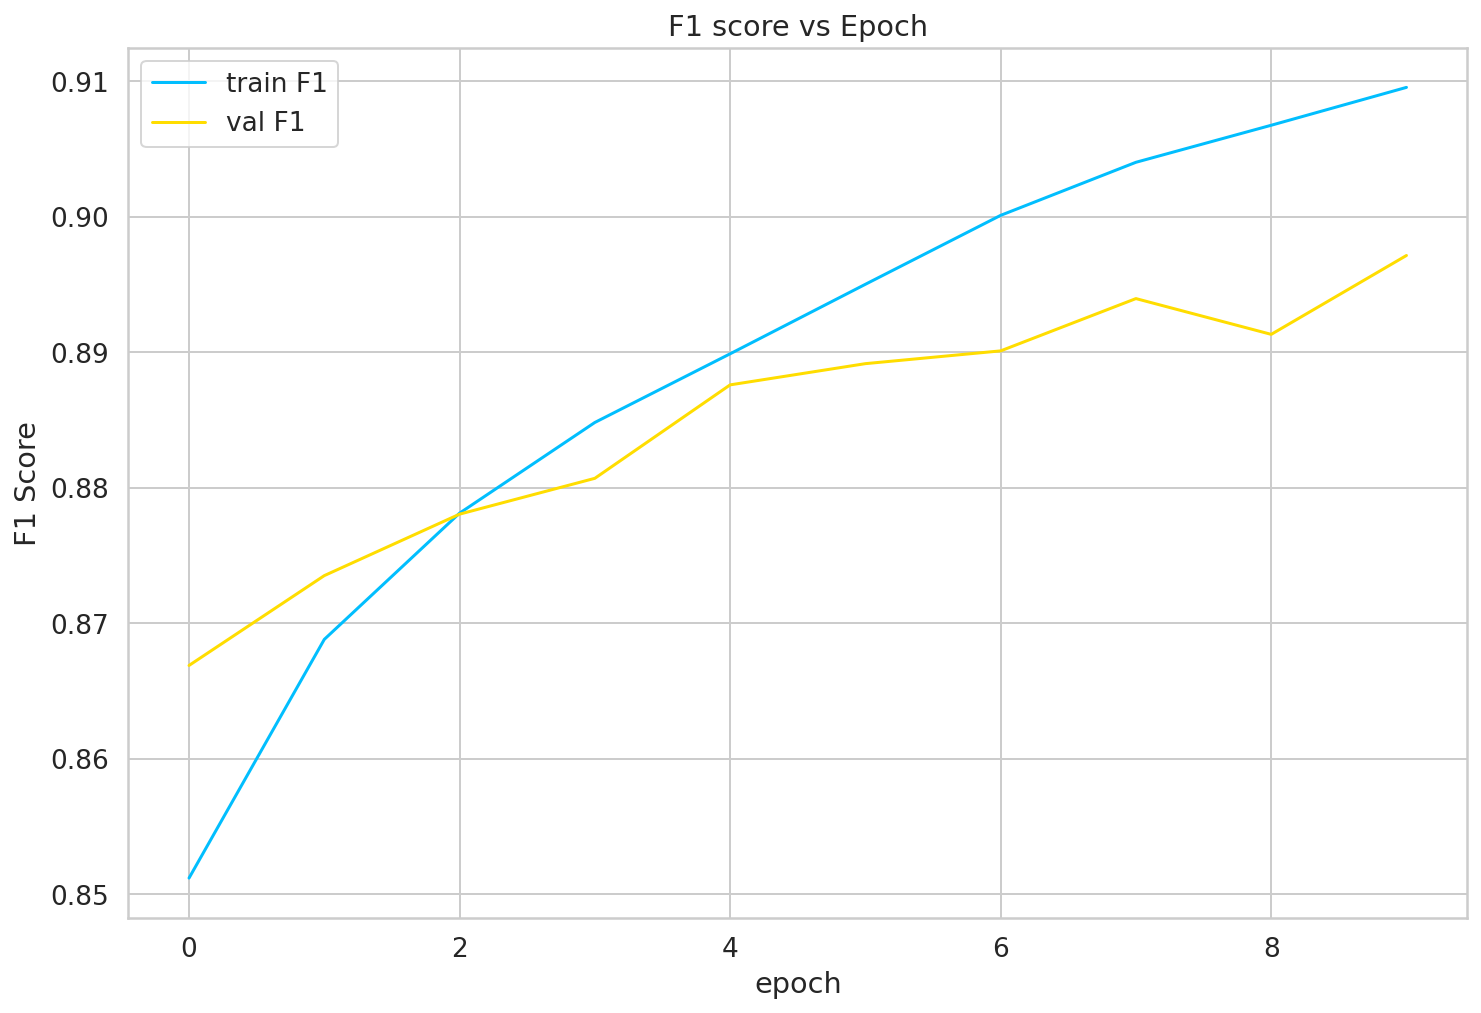

In [44]:
plt.plot(history.history['f1'],label='train F1')
plt.plot(history.history['val_f1'], label='val F1')
plt.title('F1 score vs Epoch')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

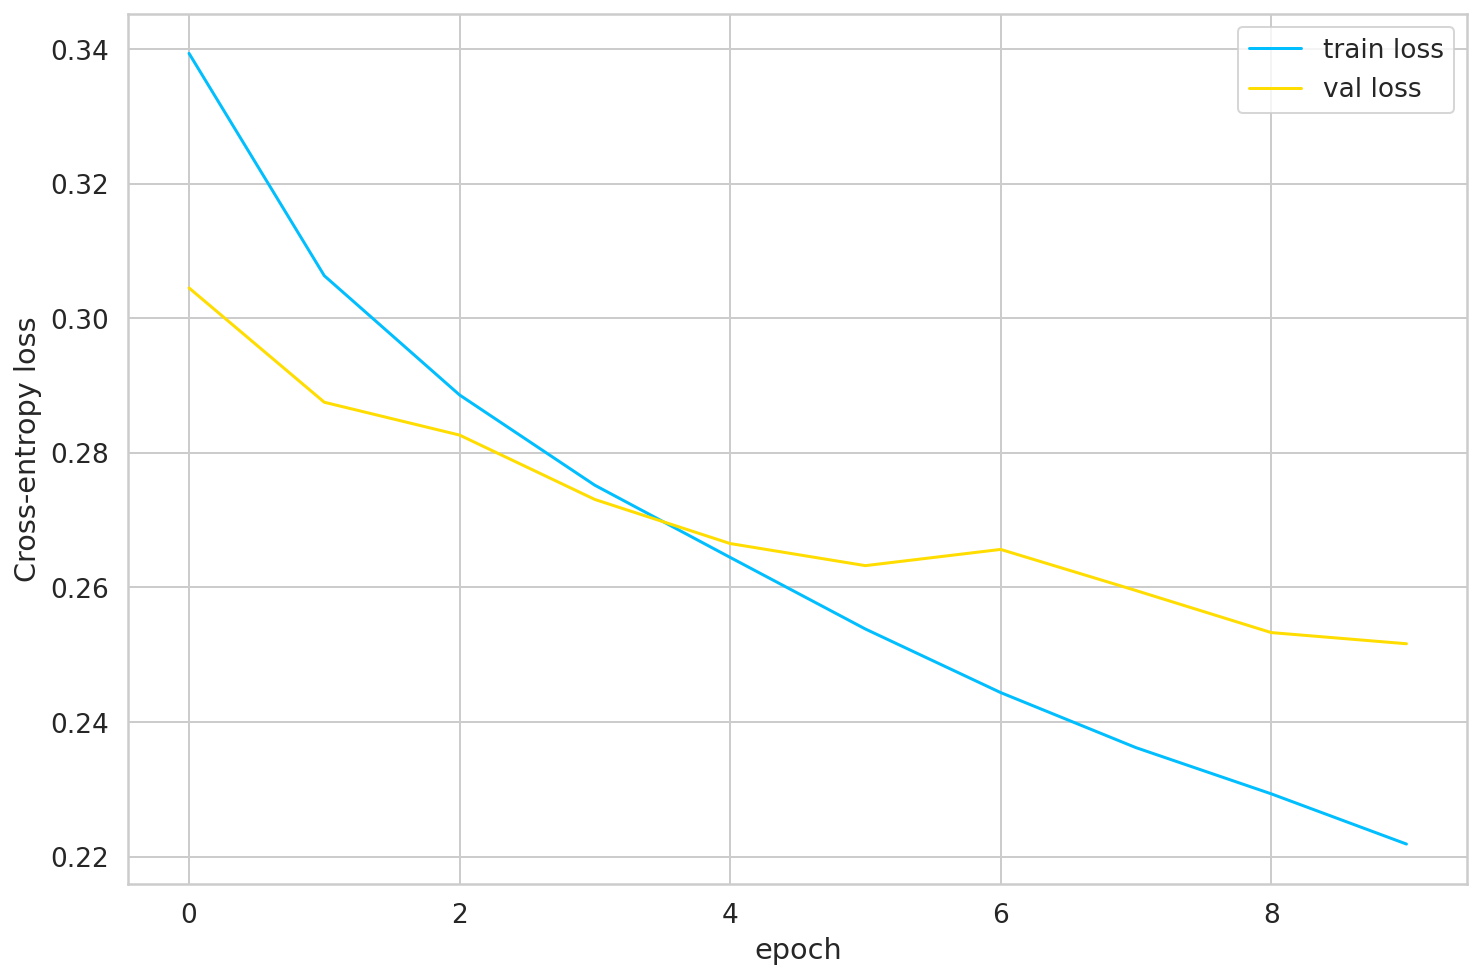

In [46]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

In [48]:
model1 = keras.Sequential()

model1.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model1.add(
  keras.layers.Dropout(rate=0.5)
)

model1.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model1.add(
  keras.layers.Dropout(rate=0.5)
)

model1.add(keras.layers.Dense(2, activation='softmax'))
model1.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [49]:
history1 = model1.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
8307/8307 [==============================] - 21s 2ms/step - loss: 0.3397 - accuracy: 0.8506 - val_loss: 0.3030 - val_accuracy: 0.8669
Epoch 2/10
8307/8307 [==============================] - 20s 2ms/step - loss: 0.3069 - accuracy: 0.8690 - val_loss: 0.2885 - val_accuracy: 0.8738
Epoch 3/10
8307/8307 [==============================] - 20s 2ms/step - loss: 0.2890 - accuracy: 0.8786 - val_loss: 0.2817 - val_accuracy: 0.8790
Epoch 4/10
8307/8307 [==============================] - 20s 2ms/step - loss: 0.2748 - accuracy: 0.8850 - val_loss: 0.2748 - val_accuracy: 0.8824
Epoch 5/10
8307/8307 [==============================] - 20s 2ms/step - loss: 0.2653 - accuracy: 0.8901 - val_loss: 0.2676 - val_accuracy: 0.8871
Epoch 6/10
8307/8307 [==============================] - 21s 3ms/step - loss: 0.2535 - accuracy: 0.8960 - val_loss: 0.2642 - val_accuracy: 0.8885
Epoch 7/10
8307/8307 [==============================] - 20s 2ms/step - loss: 0.2446 - accuracy: 0.9007 - val_loss: 0.2662 - val_ac

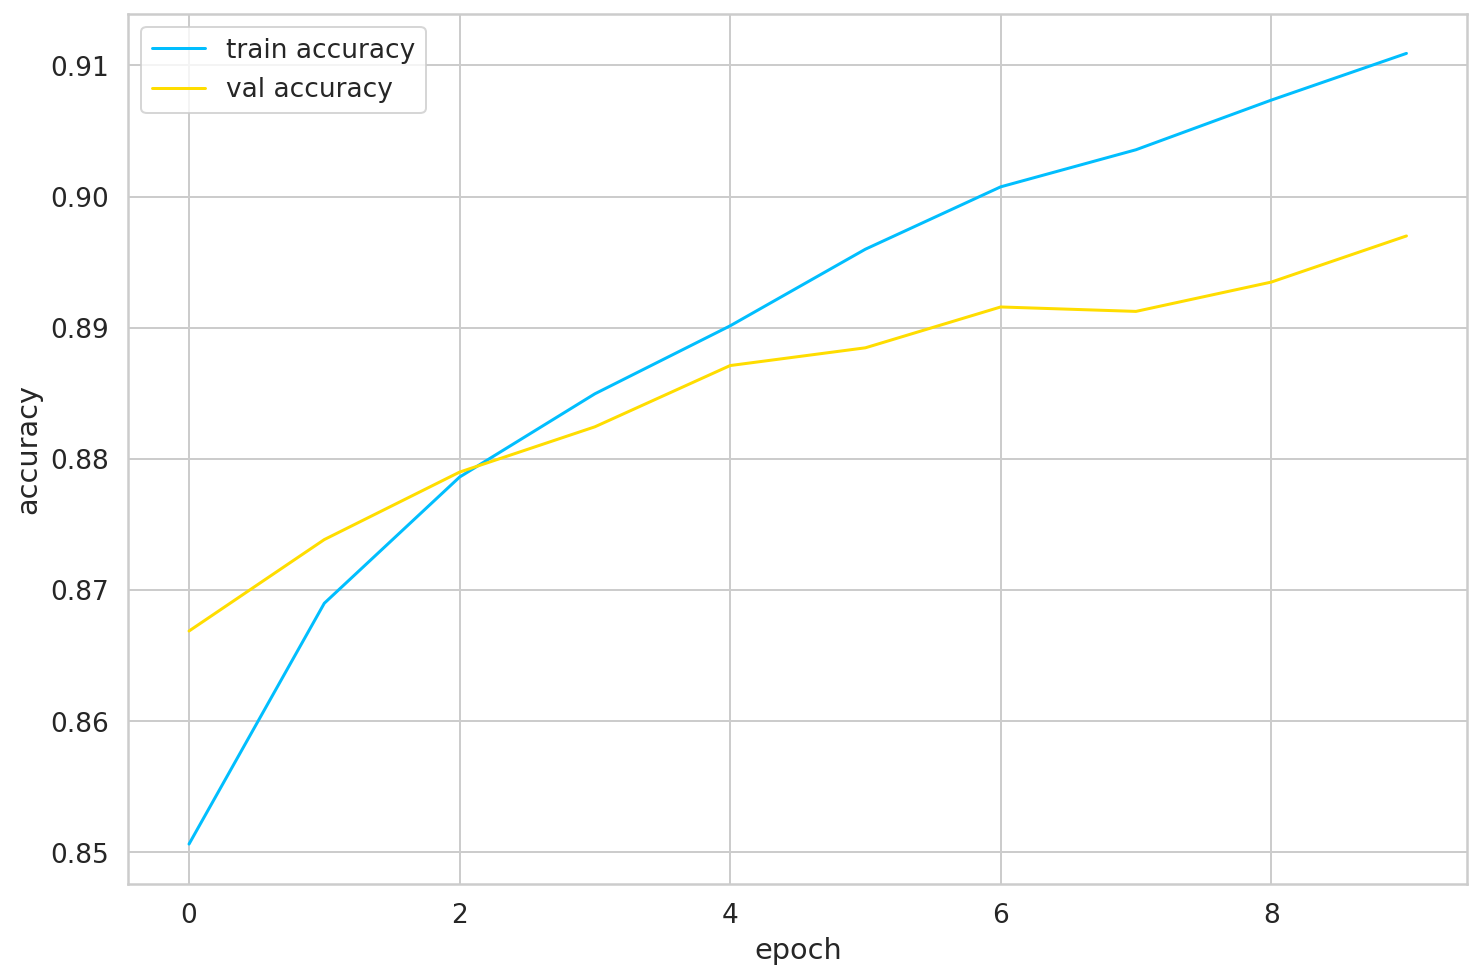

In [50]:
plt.plot(history1.history['accuracy'], label='train accuracy')
plt.plot(history1.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [51]:
model.evaluate(X_test, y_test)

513/513 [==============================] - 1s 2ms/step - loss: 0.2491 - f1: 0.8994


[0.24908626079559326, 0.8993664383888245]

In [52]:
model1.evaluate(X_test, y_test)

513/513 [==============================] - 1s 3ms/step - loss: 0.2490 - accuracy: 0.9020


[0.24899354577064514, 0.9019989967346191]

# Predictions

In [53]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

I have 4a/b/c hair and have read tons of materials about which products are best for our hair type. I thought that it was best to get away from petroleum,  and mineral oil, which are the two main ingredients in the Intense Scalp Nourishing Balm. However, I gotta go with what I know and not what I read. This stuff works!! It totally coats and seals in moisture for my porous, dry quickly hair. It is VERY light and a little goes a long way. Now, when I was growing up, everybody had long, flowing hair, when their mama's greased their scalp twice a week and they wore protective styles. What did our mama's grease our scalp with? THIS STUFF, minus the shea butter. I'm going back to the old school ways with a new school twist on it.
Good


In [54]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.03258651 0.9674135 ]]


'Good'

In [55]:
y_pred = model1.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.01788457 0.9821154 ]]


'Good'

In [ ]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")

 Don t really like modern hotels Had no character Bed was too hard  Good location rooftop pool new hotel nice balcony nice breakfast 
Good


In [ ]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.39992586 0.6000741 ]]


'Good'

In [ ]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

 Flooded bathroom from room above Painting and decorating blocking stair access  Easy to find Easy location No traffic noise in room 
Bad


In [ ]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.7276017 0.2723983]]


'Bad'

In [56]:
y_model_pred = model.predict(X_test)

In [58]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score,precision_score,recall_score


In [70]:
y_model_pred_ = np.array([np.argmax(x) for x in y_model_pred])

In [79]:
y_model_pred_.shape

(16408,)

In [80]:
y_model_pred_ = OneHotEncoder(sparse=False).fit_transform(
  y_model_pred_.reshape(-1, 1)
)

In [82]:
print(classification_report(y_test, y_model_pred_))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8186
           1       0.90      0.90      0.90      8222

   micro avg       0.90      0.90      0.90     16408
   macro avg       0.90      0.90      0.90     16408
weighted avg       0.90      0.90      0.90     16408
 samples avg       0.90      0.90      0.90     16408

